# **Практическая работа №3. Работа с растровыми данными в Rasterio**

---

**Данные для обработки:**

- Одноканальное изображение (ЦМР): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Мультиспектральное изображение (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

### **Задание 1. Чтение и исследование растровых данных**



1. Откройте одноканальное изображение ЦМР с использованием `rasterio`.


In [1]:
import rasterio


raster_path = "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"

with rasterio.open(raster_path) as src:
    print(src)
    dem = src.read(1)


<open DatasetReader name='https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif' mode='r'>


2. Извлеките и выведите метаданные растра, включая СК, разрешение, границы, количество каналов и типы данных.


In [2]:
with rasterio.open(raster_path) as src:
    print("Путь/источник:", src.name)
    print("CRS (СК):", src.crs)
    print("Разрешение (pixel size):", src.res)
    print("Границы (bounds):", src.bounds)
    print("Кол-во каналов (count):", src.count)
    print("Типы данных по каналам (dtypes):", src.dtypes)

    # Полный профиль/метаданные (полезно для записи новых растров)
    print("\nПрофиль (profile):")
    print(src.profile)


Путь/источник: https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
CRS (СК): EPSG:3857
Разрешение (pixel size): (90.0, 89.99579177642138)
Границы (bounds): BoundingBox(left=-13442488.3428, bottom=4388214.6777, right=-13058278.3428, top=4668371.5775)
Кол-во каналов (count): 1
Типы данных по каналам (dtypes): ('int16',)

Профиль (profile):
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH

3. Отобразите ширину и высоту растра, а также типы данных пикселей, чтобы понять размеры сетки и структуру данных.

In [3]:
with rasterio.open(raster_path) as src:
    print("Ширина (cols):", src.width)
    print("Высота (rows):", src.height)
    print("Размер (height, width):", (src.height, src.width))
    print("Каналов:", src.count)
    print("Типы данных по каналам (dtypes):", src.dtypes)


    print("meta['dtype']:", src.meta["dtype"])

Ширина (cols): 4269
Высота (rows): 3113
Размер (height, width): (3113, 4269)
Каналов: 1
Типы данных по каналам (dtypes): ('int16',)
meta['dtype']: int16


---



### **Задание 2. Визуализация и манипулирование растровыми каналами**



1. Визуализируйте одноканальное изображение ЦМР с использованием пользовательской цветовой карты (например, cmap='terrain').


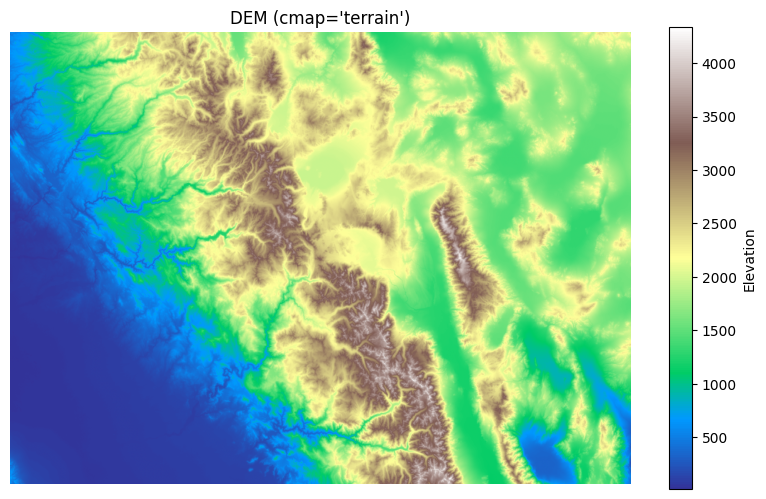

In [4]:
import matplotlib.pyplot as plt

with rasterio.open(raster_path) as src:
    dem = src.read(1, masked=True)
    plt.figure(figsize=(10, 6))
    img = plt.imshow(dem, cmap="terrain")
    plt.colorbar(img, label="Elevation")
    plt.title("DEM (cmap='terrain')")
    plt.axis("off")
    plt.show()

2. Откройте мультиспектральное изображение и визуализируйте первый канал с использованием подходящей цветовой карты.


Bands: 4
Dtypes: ('float64', 'float64', 'float64', 'float64')


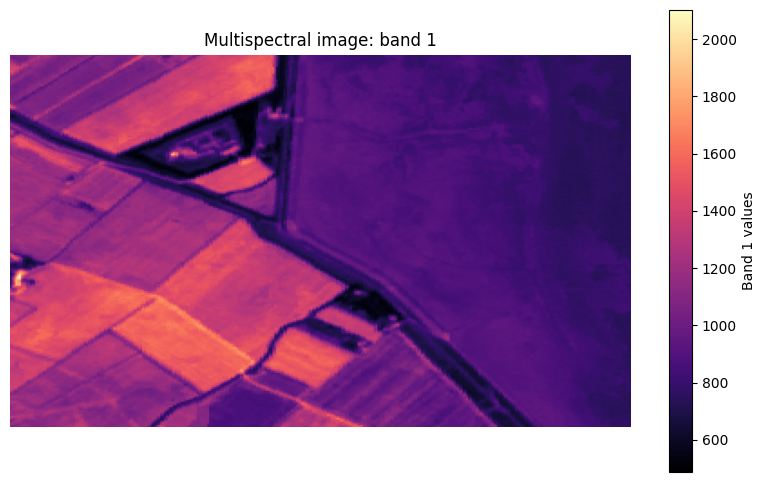

In [13]:
path = "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"

with rasterio.open(path) as src:
    print("Bands:", src.count)
    print("Dtypes:", src.dtypes)

    band1 = src.read(1, masked=True)
    plt.figure(figsize=(10, 6))
    img = plt.imshow(band1, cmap="magma")
    plt.colorbar(img, label="Band 1 values")
    plt.title("Multispectral image: band 1")
    plt.axis("off")
    plt.show()


3. Объедините несколько каналов из мультиспектрального изображения (например, Красный, Зеленый и Синий) и совместите их в один массив для создания RGB-композитного изображения.

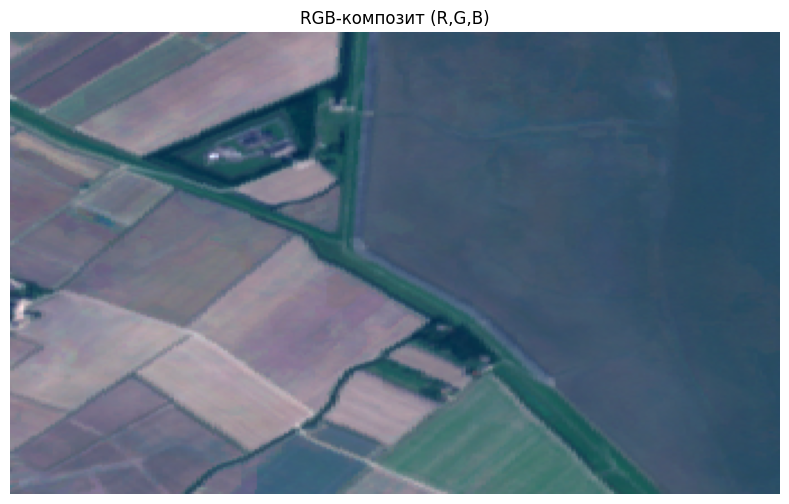

In [7]:
import numpy as np

with rasterio.open(path) as src:
    red   = src.read(1).astype("float32")
    green = src.read(2).astype("float32")
    blue  = src.read(3).astype("float32")


rgb = np.dstack((red, green, blue))

# Нормализация значений в [0, 1] для корректного отображения
rgb_min, rgb_max = np.nanmin(rgb), np.nanmax(rgb)
rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_norm)
plt.title("RGB-композит (R,G,B)")
plt.axis("off")
plt.show()

---



### **Задание 3. Обрезка растра с использованием индексации массива**



1. Откройте мультиспектральное изображение и обрежьте его с использованием спискового среза (указав диапазоны строк и столбцов).


In [8]:
# Диапазоны строк (rows, по Y) и столбцов (cols, по X)
r0, r1 = 100, 600
c0, c1 = 200, 800

with rasterio.open(path) as src:
    # Прочитать все каналы в один массив
    data = src.read()           #  срез по пространственным осям
    data_crop = data[:, r0:r1, c0:c1]

    # Пример: только первый канал
    band1 = src.read(1)
    band1_crop = band1[r0:r1, c0:c1]

print("Обрезанный стек каналов:", data_crop.shape)
print("Обрезанный 1-й канал:", band1_crop.shape)


Обрезанный стек каналов: (4, 106, 143)
Обрезанный 1-й канал: (106, 143)


2. Визуализируйте обрезанную часть изображения с использованием matplotlib, чтобы убедиться в корректном результате.


>*Примечание:*
>
> При работе с многоканальными растровыми изображениями, особенно в формате COG.TIFF (Cloud Optimized GeoTIFF), может возникнуть проблема с некорректным отображением псевдоцветного изображения. Это связано с тем, что разные каналы могут иметь различные диапазоны значений пикселей.
>
> Для корректной визуализации на шаге 2 необходимо применить нормализацию к каждому каналу перед отображением.



Включите следующую функцию в ваш код:

```python
# Функция для нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    band_norm = (band - band_min) / (band_max - band_min)
    return band_norm
```

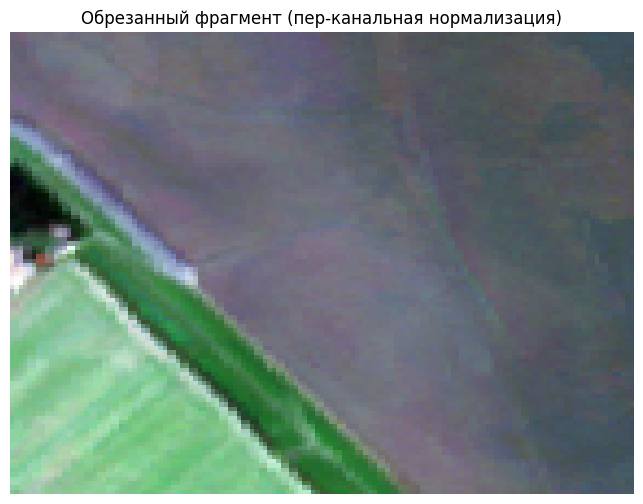

In [9]:
from rasterio.windows import Window

# нормализации канала в диапазон от 0 до 1
def normalize(band):
    band_min = band.min()
    band_max = band.max()
    if band_max == band_min:
        return np.zeros_like(band, dtype="float32")
    return (band - band_min) / (band_max - band_min)

# Диапазоны строк и столбцов
r0, r1 = 100, 600
c0, c1 = 200, 800

with rasterio.open(path) as src:
    #  окно по каждому каналу
    win = Window.from_slices((r0, r1), (c0, c1))
    r = src.read(1, window=win, masked=True).astype("float32")
    g = src.read(2, window=win, masked=True).astype("float32")
    b = src.read(3, window=win, masked=True).astype("float32")

# Нормализация каждого канала отдельно
r_n = normalize(r)
g_n = normalize(g)
b_n = normalize(b)


rgb = np.dstack([r_n, g_n, b_n])
plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Обрезанный фрагмент (пер-канальная нормализация)")
plt.axis("off")
plt.show()


3. Сохраните обрезанное подмножество растра в новый файл с именем `clipped_multispectral.tif`.

In [14]:
import rasterio
from rasterio.windows import Window, transform as win_transform

output_path = "clipped_multispectral.tif"


r0, r1 = 100, 600
c0, c1 = 200, 800

with rasterio.open(path) as src:

    window = Window.from_slices((r0, r1), (c0, c1))

    clipped_data = src.read(window=window)


    clipped_transform = win_transform(window, src.transform)

    # Копируем профиль и обновляем размеры + transform
    profile = src.profile.copy()
    profile.update({
        "height": window.height,
        "width": window.width,
        "transform": clipped_transform
    })

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(clipped_data)

print(f"Обрезанный растр сохранён в {output_path}")

Обрезанный растр сохранён в clipped_multispectral.tif


---



### **Задание 4. Вычисление NDWI (калькуляция каналов)**



1. Откройте мультиспектральное изображение и извлеките каналы Green (Зеленый) и Ближний инфракрасный (NIR).


In [15]:
with rasterio.open(path) as src:
    print("Всего каналов:", src.count)
    print("Описания каналов:")
    print(list(enumerate(src.descriptions, start=1)))

    green_idx = 2
    nir_idx = 4

    green = src.read(green_idx, masked=True)
    nir = src.read(nir_idx, masked=True)

print("Green shape:", green.shape, "dtype:", green.dtype)
print("NIR shape:", nir.shape, "dtype:", nir.dtype)


Всего каналов: 4
Описания каналов (если есть):
[(1, None), (2, None), (3, None), (4, None)]
Green shape: (206, 343) dtype: float64
NIR shape: (206, 343) dtype: float64


2. Вычислите Нормализованный разностный водный индекс ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) по формуле:

    NDWI = (Green - NIR) / (Green + NIR)

In [16]:
with rasterio.open(path) as src:
    green = src.read(2, masked=True).astype("float32")
    nir   = src.read(4, masked=True).astype("float32")

den = green + nir

ndwi = np.divide(
    (green - nir),
    den,
    out=np.full(green.shape, np.nan, dtype="float32"),
    where=(den != 0)
)


3. Визуализируйте результат NDWI с использованием цветовой карты, подходящей для воды (например, cmap='Blues'), чтобы выделить водные объекты.


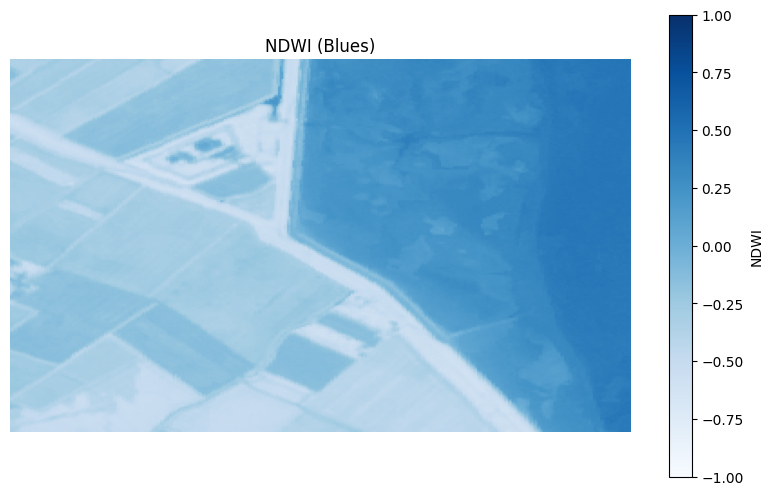

In [17]:
plt.figure(figsize=(10, 6))

im = plt.imshow(ndwi, cmap="Blues", vmin=-1, vmax=1)  # NDWI обычно лежит в [-1, 1]
plt.colorbar(im, label="NDWI")
plt.title("NDWI (Blues)")
plt.axis("off")
plt.show()




4. Сохраните полученное изображение NDWI как новый растровый файл с именем ndwi.tif.

In [18]:
out_path = "ndwi.tif"

# with rasterio.open(src_path) as src:
#     profile = src.profile.copy()


profile.update(
    dtype=rasterio.float32,
    count=1,
    nodata=np.nan
)

ndwi_out = ndwi.astype("float32")

with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(ndwi_out, 1)  # запись в 1-й канал

print("Сохранено:", out_path)


Сохранено: ndwi.tif


---



### **Задание 5. Перепроецирование растровых данных**



1. Перепроецируйте одноканальный растр ЦМР из его исходной СК в EPSG:4326 (WGS 84) с использованием функции `rasterio.warp.reproject`.


In [21]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling

dst_crs = "EPSG:4326"

with rasterio.open(raster_path) as src:
    dem = src.read(1)
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    dst_profile = src.profile.copy()
    dst_profile.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })

    import numpy as np
    dem_reproj = np.empty((height, width), dtype=dem.dtype)

    reproject(
        source=dem,
        destination=dem_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )


2. Сохраните перепроецированный растр в новый файл GeoTIFF с именем `reprojected_dem.tif`.


In [22]:
dst_path = "dem_90m_epsg4326.tif"

with rasterio.open(dst_path, "w", **dst_profile) as dst:
    dst.write(dem_reproj, 1)

print("Сохранён GeoTIFF:", dst_path)


Сохранён GeoTIFF: dem_90m_epsg4326.tif


3. Визуализируйте как исходный, так и перепроецированный наборы данных ЦМР, чтобы сравнить, как перепроецирование влияет на пространственное покрытие и разрешение.

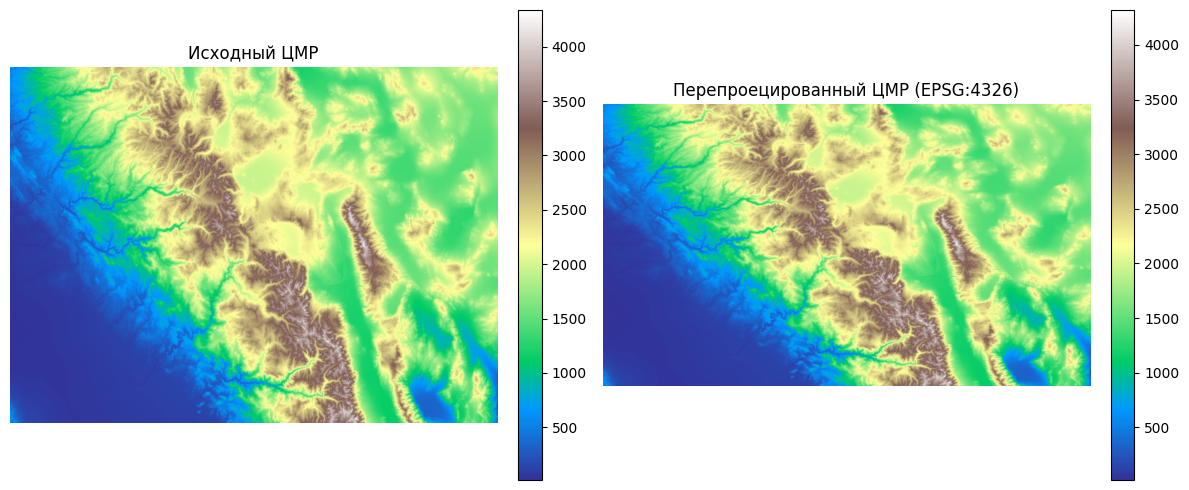

In [23]:
import rasterio
import matplotlib.pyplot as plt

src_reproj_path = "dem_90m_epsg4326.tif"

with rasterio.open(raster_path) as src_orig, rasterio.open(src_reproj_path) as src_reproj:
    dem_orig = src_orig.read(1, masked=True)
    dem_reproj = src_reproj.read(1, masked=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(dem_orig, cmap="terrain")
axes[0].set_title("Исходный ЦМР")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(dem_reproj, cmap="terrain")
axes[1].set_title("Перепроецированный ЦМР (EPSG:4326)")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


---